<a href="https://colab.research.google.com/github/confused-qy/Auto_mask_generator/blob/main/cholecseg8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the dataset

Downloaded the dataset.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("newslab/cholecseg8k")

print("Path to dataset files:", path)

100%|██████████| 2.89G/2.89G [00:40<00:00, 77.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/newslab/cholecseg8k/versions/11


Look at the data struct.

In [2]:
import os

print("Dataset directory structure: ")
for root, dirs, files in os.walk(path):
    print(root)
    break

Dataset directory structure: 
/root/.cache/kagglehub/datasets/newslab/cholecseg8k/versions/11


In [3]:
def print_tree(startpath, depth=2):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        if level > depth:
            continue
        indent = " " * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = " " * 4 * (level + 1)
        for f in files[:5]:  # only print first 5 files in each directory
            print(f"{subindent}{f}")

print_tree(path, depth=2)
print(path)

11/
    video28/
        video28_00400/
            frame_476_endo_color_mask.png
            frame_427_endo_color_mask.png
            frame_465_endo_color_mask.png
            frame_423_endo.png
            frame_400_endo_watershed_mask.png
        video28_00480/
            frame_503_endo_color_mask.png
            frame_545_endo.png
            frame_504_endo_color_mask.png
            frame_523_endo_mask.png
            frame_497_endo.png
        video28_00320/
            frame_361_endo_color_mask.png
            frame_364_endo_watershed_mask.png
            frame_352_endo_mask.png
            frame_362_endo_watershed_mask.png
            frame_370_endo_color_mask.png
        video28_00160/
            frame_195_endo_watershed_mask.png
            frame_163_endo_color_mask.png
            frame_234_endo_mask.png
            frame_180_endo_watershed_mask.png
            frame_183_endo.png
        video28_00000/
            frame_34_endo.png
            frame_56_endo_watershed_mask

Example figures of the dataset.

/root/.cache/kagglehub/datasets/newslab/cholecseg8k/versions/11


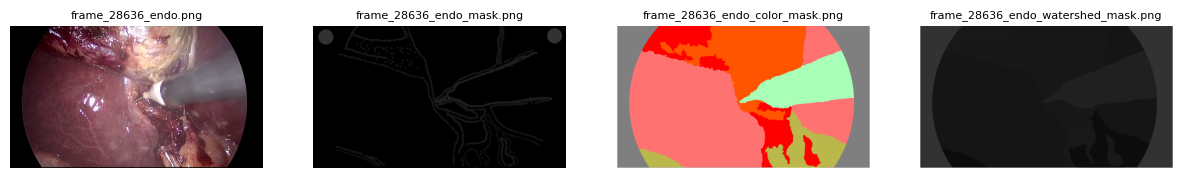

In [4]:
import cv2
import matplotlib.pyplot as plt

def show_multiple(base_path, filenames):
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(filenames, 1):
        target_path = None
        for root, dirs, files in os.walk(base_path):
            if filename in files:
                target_path = os.path.join(root, filename)
                break
        if target_path:
            img = cv2.imread(target_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, len(filenames), i)
            plt.imshow(img)
            plt.title(filename, fontsize=8)
            plt.axis("off")
        else:
            print(f"File {filename} not found in {base_path}")
    plt.show()

# Show the images
print(path)
show_multiple(path, [
    "frame_28636_endo.png",
    "frame_28636_endo_mask.png",
    "frame_28636_endo_color_mask.png",
    "frame_28636_endo_watershed_mask.png"
])

In [5]:
import os

# 查看当前目录
print("当前目录内容：", os.listdir())

# 查看 Depth-Anything-V2 目录内容
if os.path.exists("Depth-Anything-V2"):
    print("Depth-Anything-V2 内容：", os.listdir("Depth-Anything-V2"))

当前目录内容： ['.config', 'sample_data']


In [6]:
import sys
import numpy as np

print("Python path:", sys.executable)
print("Numpy version:", np.__version__)

if not hasattr(np, 'float32'):
    raise RuntimeError("Numpy is not available")

Python path: /usr/bin/python3
Numpy version: 2.0.2


In [7]:
%pip install numpy

import torch
import numpy as np

# Patch for torch numpy extension if needed
torch.utils._import_npy_extension = lambda: None

print(torch.__version__)
print(np.__version__)
print(torch.from_numpy(np.zeros((2,2))))

2.8.0+cu126
2.0.2
tensor([[0., 0.],
        [0., 0.]], dtype=torch.float64)


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git

fatal: destination path 'Depth-Anything-V2' already exists and is not an empty directory.


In [16]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git /content/drive/MyDrive/Depth-Anything-V2

Cloning into '/content/drive/MyDrive/Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Total 142 (delta 0), reused 0 (delta 0), pack-reused 142 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 10.03 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (74/74), done.


In [17]:
%cd /content/drive/MyDrive/Depth-Anything-V2
!pip install -r requirements.txt
!pip install opencv-python matplotlib huggingface_hub

/content/drive/MyDrive/Depth-Anything-V2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
  At

Traceback (most recent call last):
  File "/usr/lib/python3.12/importlib/metadata/__init__.py", line 819, in read_text
    return self._path.joinpath(filename).read_text(encoding='utf-8')
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/pathlib.py", line 1027, in read_text
^C


In [1]:
import sys
sys.path.append("/content/drive/MyDrive/Depth-Anything-V2")  # 或者你 clone 的路径

In [7]:
import torch
from depth_anything_v2.dpt import DepthAnythingV2

model = DepthAnythingV2(encoder='vitl', features=256, out_channels=[256, 512, 1024, 1024])
state_dict = torch.load('/content/drive/MyDrive/Depth-Anything-V2/checkpoints/depth_anything_v2_vitl.pth', map_location='cpu', weights_only=False)
model.load_state_dict(state_dict)
model.eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal